# Basic feature interrelation analysis using the 'fip3' library

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import csv

from fip import profiles

In [45]:
DATASET_NAME = 'ChEMBL28'
DATASET_LINK = '../../scratch/data/chembl_28/chembl_compounds_activities_features.csv'
OUTPUT_FIGURE_PATH = '../../scratch/data/chembl_28/pix'

FEATURES_NAME = 'ECFP1-like substructures'
COOCCURRENCE_MX_LINK = '../../scratch/data/chembl_28/ec_fragments_r1_coomx.csv'
COOCCURRENCE_MX_VECTOR_COUNT = 2066376

MINIMAL_COOCCURRENCE_CUTOFF = 100  # How many co-occurrences are needed to start tracking the relation

HYBRID_FEATURES_NAME = FEATURES_NAME + " and ChEMBL activities"
HYBRID_COOCCURRENCE_MX_LINK = '../../scratch/data/chembl_28/ec_fragments_r1_activities_coomx.csv'
HYBRID_COOCCURRENCE_MX_VECTOR_COUNT = COOCCURRENCE_MX_VECTOR_COUNT

REFERENCE_DATASET_NAME = 'ZINC_DM'
REFERENCE_DATASET_LINK = '../../scratch/data/zinc_dark_matter/zinc_dm_in_stock_features.csv'
REFERENCE_COOCCURRENCE_MX_LINK = '../../scratch/data/zinc_dark_matter/zinc_dm_in_stock_ec_fragments_r1_coomx.csv'
REFERENCE_COOCCURRENCE_MX_VECTOR_COUNT = 5063486

# Derived from primary dataset, adjusted for size difference
REFERENCE_MINIMAL_COOCCURRENCE_CUTOFF = int(MINIMAL_COOCCURRENCE_CUTOFF * 
                                            (REFERENCE_COOCCURRENCE_MX_VECTOR_COUNT /
                                             COOCCURRENCE_MX_VECTOR_COUNT))

245

## Loading interrelation profiles
From interrelation files already preprocessed by scripts in fip3/scripts

In [3]:
p = profiles.CooccurrenceProfile.from_dataframe(
    pd.read_csv(COOCCURRENCE_MX_LINK), min_cutoff_value=MINIMAL_COOCCURRENCE_CUTOFF)
p

In [4]:
p.df

value
feature1   feature2                
C=O        C=O              1424230
           Cc(c)c            624876
           c-n(c)n            37580
           c=O               120205
           cC                273990
...                             ...
N=c([nH])n cc(c)Cl              141
CCS        cN=S                 149
cn(c)n     nc(-n)[nH]           565
CC(N)=O    cS(F)(F)(F)(F)F      106
CC(F)(F)F  nc(-n)[nH]           175

[47478 rows x 1 columns]

## General characterization of a co-occurrence profile

In [5]:
print(f"There are {len(p.distinct_features())} distinct {FEATURES_NAME} within {DATASET_NAME}.")

There are 897 distinct ECFP1-like substructures within ChEMBL28.


In [6]:
self_relations_values = p.select_self_relations()['value']
self_relations_values

feature1    feature2  
C=O         C=O           1424230
Cc(c)c      Cc(c)c         717878
c-n(c)n     c-n(c)n         55340
c=O         c=O            222434
cC          cC             408262
                           ...   
c-c(c)[o+]  c-c(c)[o+]        134
nc(n)[nH]   nc(n)[nH]         120
N=c(n)[nH]  N=c(n)[nH]        117
CC(C)=c     CC(C)=c           122
cn(C)[se]   cn(C)[se]         109
Name: value, Length: 897, dtype: int64

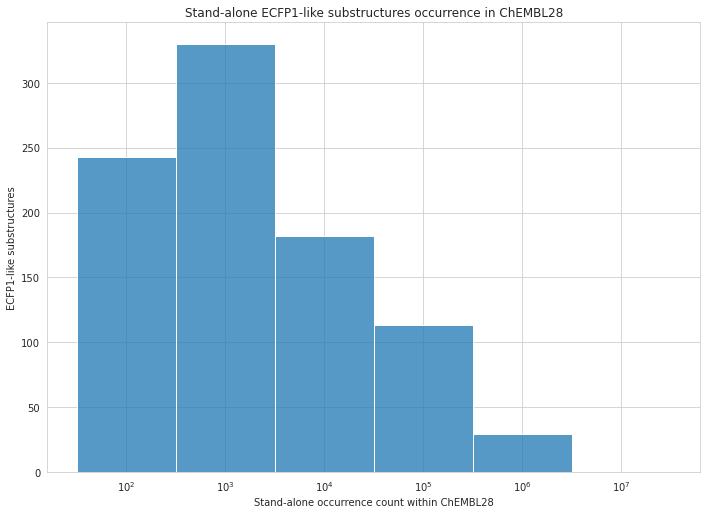

In [7]:
title = f"Stand-alone {FEATURES_NAME} occurrence in {DATASET_NAME}"
a4_dims = (11.7, 8.27)
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=a4_dims)
sns.histplot(self_relations_values, log_scale=True, discrete=True)
ax.set(title=title, xlabel=f"Stand-alone occurrence count within {DATASET_NAME}", ylabel=f"{FEATURES_NAME}")
plt.savefig(f"{OUTPUT_FIGURE_PATH}/{title}.svg", format="svg")
#plt.close()

In [8]:
cooccurrence_values = p.select_raw_interrelations()['value']
cooccurrence_values

feature1    feature2       
C=O         Cc(c)c             624876
            c-n(c)n             37580
            c=O                120205
            cC                 273990
            cC(c)=O             30748
                                ...  
N=c([nH])n  cc(c)Cl               141
CCS         cN=S                  149
cn(c)n      nc(-n)[nH]            565
CC(N)=O     cS(F)(F)(F)(F)F       106
CC(F)(F)F   nc(-n)[nH]            175
Name: value, Length: 46581, dtype: int64

In [9]:
print(f"There is in total {self_relations_values.sum()} feature stand-alone occurrences and \
{cooccurrence_values.sum()} feature co-occurrences for {FEATURES_NAME} within {DATASET_NAME}")

There is in total 33688980 feature stand-alone occurrences and 276946302 feature co-occurrences for ECFP1-like substructures within ChEMBL28


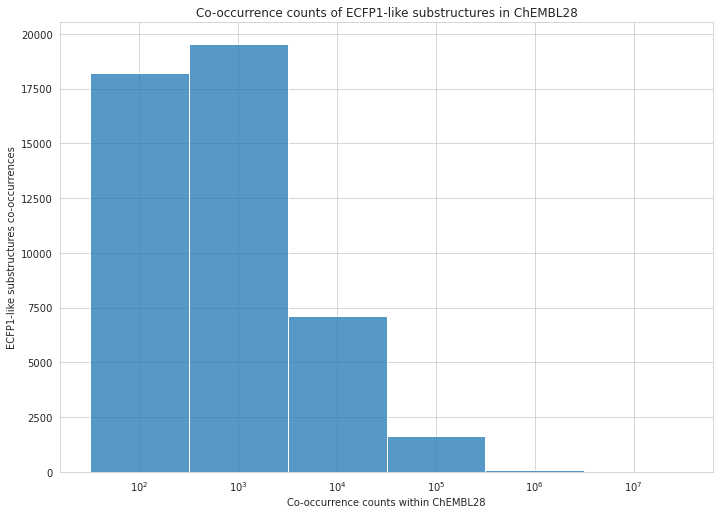

In [10]:
title = f"Co-occurrence counts of {FEATURES_NAME} in {DATASET_NAME}"
a4_dims = (11.7, 8.27)
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=a4_dims)
sns.histplot(cooccurrence_values, log_scale=True, discrete=True)
ax.set(title=title, xlabel=f"Co-occurrence counts within {DATASET_NAME}",
       ylabel=f"{FEATURES_NAME} co-occurrences")
plt.savefig(f"{OUTPUT_FIGURE_PATH}/{title}.svg", format="svg")
#plt.close()

In [11]:
print(f"The maximum theoretical number of different feature interrelations of the observed {FEATURES_NAME} \
within {DATASET_NAME} would be {int(p.num_max_interrelations())}, whereas the number of actual observed \
interrelations is only {p.num_raw_interrelations()}. Therefore, the interrelation matrix population ratio is \
approx. {p.num_raw_interrelations() / p.num_max_interrelations():.4f}.")

The maximum theoretical number of different feature interrelations of the observed ECFP1-like substructures within ChEMBL28 would be 401856, whereas the number of actual observed interrelations is only 46581. Therefore, the interrelation matrix population ratio is approx. 0.1159.


In [12]:
print(f"The mean co-occurrence value for {FEATURES_NAME} within {DATASET_NAME} \
is {p.mean_raw_interrelation_value():.2f}, \
with the standard deviation of {p.standard_raw_interrelation_deviation():.2f}. \
The mean stand-alone value is {p.mean_self_relation_value():.2f}, \
with the standard deviation of {p.standard_self_relation_deviation():.2f}.")

The mean co-occurrence value for ECFP1-like substructures within ChEMBL28 is 5945.48, with the standard deviation of 30064.68. The mean stand-alone value is 37557.39, with the standard deviation of 139526.54.


## General characterization of pointwise mutual information profile

In [13]:
p = profiles.CooccurrenceProbabilityProfile.from_cooccurrence_profile(
    p, vector_count=COOCCURRENCE_MX_VECTOR_COUNT)
p

In [14]:
p.select_self_relations()['value']

feature1    feature2  
C=O         C=O           0.689240
Cc(c)c      Cc(c)c        0.347409
c-n(c)n     c-n(c)n       0.026781
c=O         c=O           0.107644
cC          cC            0.197574
                            ...   
c-c(c)[o+]  c-c(c)[o+]    0.000065
nc(n)[nH]   nc(n)[nH]     0.000058
N=c(n)[nH]  N=c(n)[nH]    0.000057
CC(C)=c     CC(C)=c       0.000059
cn(C)[se]   cn(C)[se]     0.000053
Name: value, Length: 897, dtype: float64

In [15]:
p.select_self_relations()['value'].min()

4.8393903142506496e-05

In [16]:
p.select_raw_interrelations()['value'].min()

4.8393903142506496e-05

In [17]:
p = profiles.PointwiseMutualInformationProfile.from_cooccurrence_probability_profile(p)

p

In [18]:
p.df

value
feature1   feature2                 
C=O        C=O              0.000000
           Cc(c)c           0.336752
           c-n(c)n         -0.021437
           c=O             -0.350960
           cC              -0.038451
...                              ...
N=c([nH])n cc(c)Cl          1.755450
CCS        cN=S             2.678707
cn(c)n     nc(-n)[nH]       4.683056
CC(N)=O    cS(F)(F)(F)(F)F  0.540092
CC(F)(F)F  nc(-n)[nH]       2.898813

[47478 rows x 1 columns]

In [19]:
pmi_values = p.select_raw_interrelations()['value']
pmi_values

feature1    feature2       
C=O         Cc(c)c             0.336752
            c-n(c)n           -0.021437
            c=O               -0.350960
            cC                -0.038451
            cC(c)=O            0.536921
                                 ...   
N=c([nH])n  cc(c)Cl            1.755450
CCS         cN=S               2.678707
cn(c)n      nc(-n)[nH]         4.683056
CC(N)=O     cS(F)(F)(F)(F)F    0.540092
CC(F)(F)F   nc(-n)[nH]         2.898813
Name: value, Length: 46581, dtype: float64

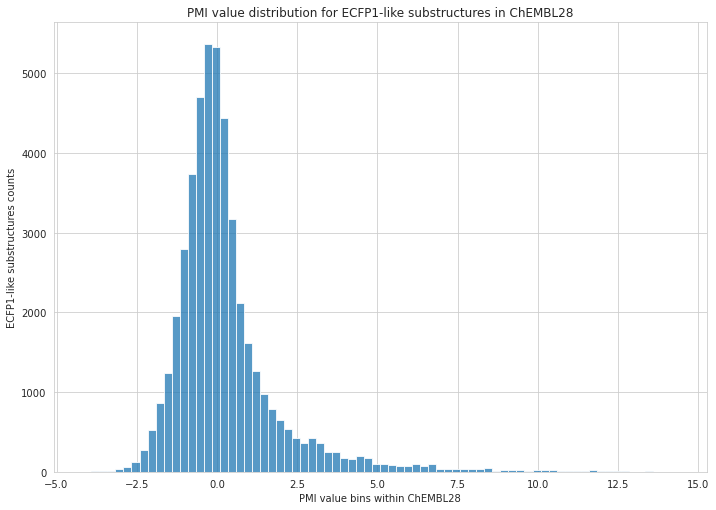

In [20]:
title = f"PMI value distribution for {FEATURES_NAME} in {DATASET_NAME}"
a4_dims = (11.7, 8.27)
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=a4_dims)
sns.histplot(pmi_values, binwidth=0.25)
ax.set(title=title, xlabel=f"PMI value bins within {DATASET_NAME}", ylabel=f"{FEATURES_NAME} counts")
plt.savefig(f"{OUTPUT_FIGURE_PATH}/{title}.svg", format="svg")
#plt.close()

In [21]:
print(f"The mean PMI value for {FEATURES_NAME} within {DATASET_NAME} \
is {p.mean_raw_interrelation_value():.2f}, \
with the standard deviation of {p.standard_raw_interrelation_deviation():.2f}. \
The mean stand-alone value is {p.mean_self_relation_value():.2f}, \
with the standard deviation of {p.standard_self_relation_deviation():.2f}.")

The mean PMI value for ECFP1-like substructures within ChEMBL28 is 0.25, with the standard deviation of 1.70. The mean stand-alone value is 0.00, with the standard deviation of 0.00.


In [22]:
major_pmi_values = p.select_major_interrelations(2)['value']
major_pmi_values

feature1     feature2  
c-n(c)n      cc(c)-n       4.251786
cc([nH])=O   nc([nH])=O    5.251617
C#N          cC#N          4.446057
cBr          cc(c)Br       4.726801
cC[n+]       c[n+](c)C     6.626132
                             ...   
c-c(c)o      nc(O)s        4.046249
CS(C)(=N)=O  cNc           4.148195
cN=S         cNc           4.374894
             ncn           3.816252
cn(c)n       nc(-n)[nH]    4.683056
Name: value, Length: 2089, dtype: float64

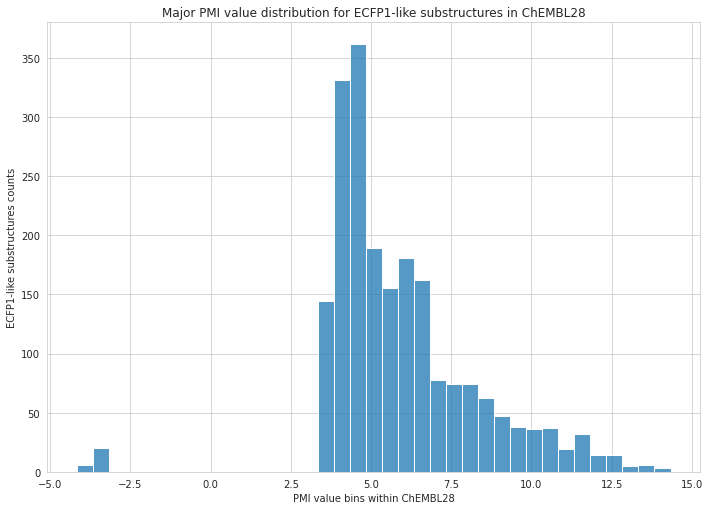

In [23]:
title = f"Major PMI value distribution for {FEATURES_NAME} in {DATASET_NAME}"
a4_dims = (11.7, 8.27)
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=a4_dims)
sns.histplot(major_pmi_values, binwidth=0.5)
ax.set(title=title, xlabel=f"PMI value bins within {DATASET_NAME}", ylabel=f"{FEATURES_NAME} counts")
plt.savefig(f"{OUTPUT_FIGURE_PATH}/{title}.svg", format="svg")
#plt.close()

In [24]:
p.mean_raw_interrelation_value()

0.2533206760082737

## Graph visualization of PMI profile

In [25]:
graph = nx.Graph()
major_pmi_values = p.select_major_interrelations(2)

for feature_pair, value in major_pmi_values[major_pmi_values['value'] > 0].iterrows():
    graph.add_edge(feature_pair[0], feature_pair[1], weight=float(value))
graph

In [26]:
title = f"Kamada-Kawai graph visualization of major PMI interrelations for {FEATURES_NAME} in {DATASET_NAME}"
dims = (40, 40)
fig, ax = plt.subplots(figsize=dims)
nx.draw_kamada_kawai(graph, ax=ax, alpha=0.5, node_size=30, label=title)
plt.savefig(f"{OUTPUT_FIGURE_PATH}/{title}.svg", format="svg")
plt.close()

In [27]:
title = f"Circular graph visualization of major PMI interrelations for {FEATURES_NAME} in {DATASET_NAME}"
dims = (40, 40)
fig, ax = plt.subplots(figsize=dims)
nx.draw_circular(graph, ax=ax, alpha=0.2, node_size=30)
plt.savefig(f"{OUTPUT_FIGURE_PATH}/{title}.svg", format="svg")
plt.close()

In [28]:
title = f"A generic graph visualization of major PMI interrelations for {FEATURES_NAME} in {DATASET_NAME}"
dims = (40, 40)
fig, ax = plt.subplots(figsize=dims)
nx.draw_networkx(graph, ax=ax, alpha=0.1, node_size=30)
plt.savefig(f"{OUTPUT_FIGURE_PATH}/{title}.svg", format="svg")
plt.close()

## General characterization of a hybrid co-occurrence profile

In [29]:
q = profiles.CooccurrenceProfile.from_dataframe(
    pd.read_csv(HYBRID_COOCCURRENCE_MX_LINK), min_cutoff_value=MINIMAL_COOCCURRENCE_CUTOFF)
q

In [30]:
q.df

value
feature1                                 feature2                                           
C=O                                      C=O                                         1417382
                                         Cc(c)c                                       621764
                                         c-n(c)n                                       37498
                                         c=O                                          119809
                                         cC                                           272969
...                                                                                      ...
Ubiquitin carboxyl-terminal hydrolase 25 cc(c)c                                          103
CC                                       Histone-lysine N-methyltransferase SUV39H2      107
Ubiquitin carboxyl-terminal hydrolase 28 cc(c)c                                          107
Sepiapterin reductase                    ccs                                             117
                                         csc                                             157

[82528 rows x 1 columns]

In [31]:
target_set = set()
with open(DATASET_LINK, 'r') as dataset:
    reader = csv.DictReader(dataset)
    for row in reader:
        activities = row['chembl_activities'].split(" | ")
        for activity in activities:
            activity = activity.strip()
            if activity:
                target_set.add(activity)
len(target_set)

5507

In [32]:
interrelation_type = ['feature-feature', 'feature-activity', 'activity-activity']
q.df['type'] = [interrelation_type[sum((x in target_set, y in target_set))]
                                   for x, y in zip(q.df.index.get_level_values(0),
                                                   q.df.index.get_level_values(1))]
q.df

value  \
feature1                                 feature2                                              
C=O                                      C=O                                         1417382   
                                         Cc(c)c                                       621764   
                                         c-n(c)n                                       37498   
                                         c=O                                          119809   
                                         cC                                           272969   
...                                                                                      ...   
Ubiquitin carboxyl-terminal hydrolase 25 cc(c)c                                          103   
CC                                       Histone-lysine N-methyltransferase SUV39H2      107   
Ubiquitin carboxyl-terminal hydrolase 28 cc(c)c                                          107   
Sepiapterin reductase                    ccs                                             117   
                                         csc                                             157   

                                                                                                 type  
feature1                                 feature2                                                      
C=O                                      C=O                                          feature-feature  
                                         Cc(c)c                                       feature-feature  
                                         c-n(c)n                                      feature-feature  
                                         c=O                                          feature-feature  
                                         cC                                           feature-feature  
...                                                                                               ...  
Ubiquitin carboxyl-terminal hydrolase 25 cc(c)c                                      feature-activity  
CC                                       Histone-lysine N-methyltransferase SUV39H2  feature-activity  
Ubiquitin carboxyl-terminal hydrolase 28 cc(c)c                                      feature-activity  
Sepiapterin reductase                    ccs                                         feature-activity  
                                         csc                                         feature-activity  

[82528 rows x 2 columns]

In [33]:
q.select_self_relations().loc[q.df.type=='activity-activity']

,,value,type
feature1,feature2,,
Aldehyde dehydrogenase 1A1,Aldehyde dehydrogenase 1A1,2113,activity-activity
Anandamide amidohydrolase,Anandamide amidohydrolase,2103,activity-activity
Bloom syndrome protein,Bloom syndrome protein,328,activity-activity
Adrenergic receptor alpha-1,Adrenergic receptor alpha-1,2792,activity-activity
Rattus norvegicus,Rattus norvegicus,2923,activity-activity
...,...,...,...
Ubiquitin carboxyl-terminal hydrolase 30,Ubiquitin carboxyl-terminal hydrolase 30,436,activity-activity
Phosphatidylcholine-sterol acyltransferase,Phosphatidylcholine-sterol acyltransferase,134,activity-activity
Serine protease HTRA1,Serine protease HTRA1,184,activity-activity


In [34]:
print(f"There are {len(q.distinct_features())} distinct {HYBRID_FEATURES_NAME} within {DATASET_NAME}, \
of which there are {len(q.select_self_relations().loc[q.df.type=='activity-activity'])} ChEMBL activities.")

There are 2078 distinct ECFP1-like substructures and ChEMBL activities within ChEMBL28, of which there are 1117 ChEMBL activities.


In [35]:
hybrid_self_relations_values = q.select_self_relations()['value']
hybrid_self_relations_values

feature1                                    feature2                                  
C=O                                         C=O                                           1417382
Cc(c)c                                      Cc(c)c                                         714416
c-n(c)n                                     c-n(c)n                                         55160
c=O                                         c=O                                            221633
cC                                          cC                                             406260
                                                                                           ...   
Phosphatidylcholine-sterol acyltransferase  Phosphatidylcholine-sterol acyltransferase        134
Serine protease HTRA1                       Serine protease HTRA1                             184
Amylin receptor AMY3; CALCR/RAMP3           Amylin receptor AMY3; CALCR/RAMP3                 141
"Acetyl-coenzyme A synthetase  

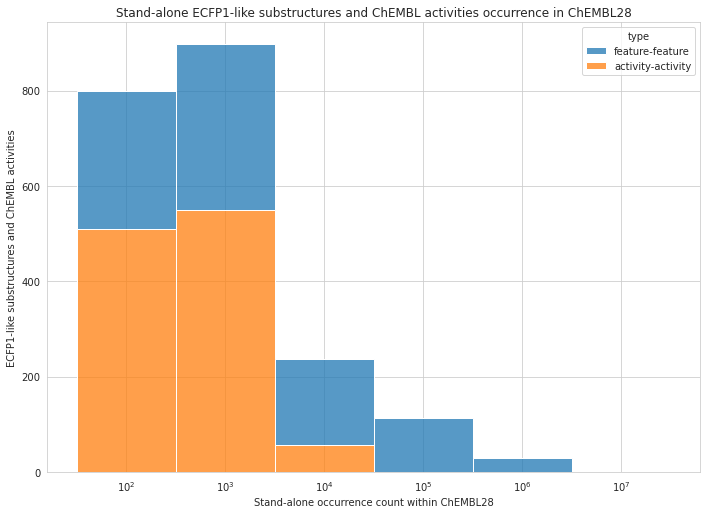

In [36]:
title = f"Stand-alone {HYBRID_FEATURES_NAME} occurrence in {DATASET_NAME}"
a4_dims = (11.7, 8.27)
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=a4_dims)
sns.histplot(q.select_self_relations(), log_scale=True, discrete=True, 
             x="value", hue="type", multiple="stack")
ax.set(title=title, xlabel=f"Stand-alone occurrence count within {DATASET_NAME}",
       ylabel=f"{HYBRID_FEATURES_NAME}")
plt.savefig(f"{OUTPUT_FIGURE_PATH}/{title}.svg", format="svg")
#plt.close()

In [37]:
hybrid_cooccurrence_values = q.select_raw_interrelations()['value']
hybrid_cooccurrence_values

feature1                                  feature2                                  
C=O                                       Cc(c)c                                        621764
                                          c-n(c)n                                        37498
                                          c=O                                           119809
                                          cC                                            272969
                                          cC(c)=O                                        30629
                                                                                         ...  
Ubiquitin carboxyl-terminal hydrolase 25  cc(c)c                                           103
CC                                        Histone-lysine N-methyltransferase SUV39H2       107
Ubiquitin carboxyl-terminal hydrolase 28  cc(c)c                                           107
Sepiapterin reductase                     ccs               

In [38]:
print(f"There is in total {self_relations_values.sum()} feature stand-alone occurrences and \
{hybrid_cooccurrence_values.sum()} feature co-occurrences for {HYBRID_FEATURES_NAME} within {DATASET_NAME}")

There is in total 33688980 feature stand-alone occurrences and 290450895 feature co-occurrences for ECFP1-like substructures and ChEMBL activities within ChEMBL28


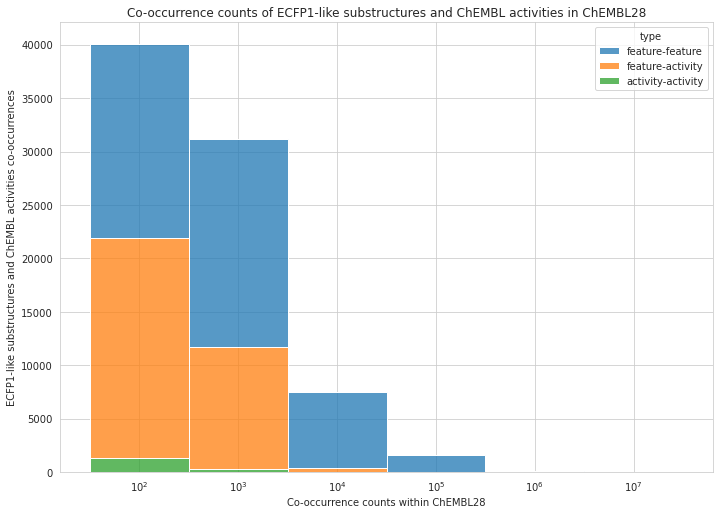

In [39]:
title = f"Co-occurrence counts of {HYBRID_FEATURES_NAME} in {DATASET_NAME}"
a4_dims = (11.7, 8.27)
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=a4_dims)
sns.histplot(q.select_raw_interrelations(), log_scale=True, discrete=True,
             x="value", hue="type", multiple="stack")
ax.set(title=title, xlabel=f"Co-occurrence counts within {DATASET_NAME}",
       ylabel=f"{HYBRID_FEATURES_NAME} co-occurrences")
plt.savefig(f"{OUTPUT_FIGURE_PATH}/{title}.svg", format="svg")
#plt.close()

In [40]:
q = profiles.CooccurrenceProbabilityProfile.from_cooccurrence_profile(
    q, vector_count=HYBRID_COOCCURRENCE_MX_VECTOR_COUNT)
q = profiles.PointwiseMutualInformationProfile.from_cooccurrence_probability_profile(q)

In [41]:
q.df

value  \
feature1                                 feature2                                               
C=O                                      C=O                                         0.000000   
                                         Cc(c)c                                      0.343477   
                                         c-n(c)n                                    -0.012935   
                                         c=O                                        -0.343562   
                                         cC                                         -0.029792   
...                                                                                       ...   
Ubiquitin carboxyl-terminal hydrolase 25 cc(c)c                                      2.015672   
CC                                       Histone-lysine N-methyltransferase SUV39H2 -0.849671   
Ubiquitin carboxyl-terminal hydrolase 28 cc(c)c                                      1.995351   
Sepiapterin reductase                    ccs                                         1.394693   
                                         csc                                         0.693224   

                                                                                         type  
feature1                                 feature2                                              
C=O                                      C=O                                                   
                                         Cc(c)c                                      0.343477  
                                         c-n(c)n                                    -0.012935  
                                         c=O                                        -0.343562  
                                         cC                                         -0.029792  
...                                                                                       ...  
Ubiquitin carboxyl-terminal hydrolase 25 cc(c)c                                      2.015672  
CC                                       Histone-lysine N-methyltransferase SUV39H2 -0.849671  
Ubiquitin carboxyl-terminal hydrolase 28 cc(c)c                                      1.995351  
Sepiapterin reductase                    ccs                                         1.394693  
                                         csc                                         0.693224  

[82528 rows x 2 columns]

In [42]:
# Fix the type write-through
q.df['type'] = [interrelation_type[sum((x in target_set, y in target_set))]
                                   for x, y in zip(q.df.index.get_level_values(0),
                                                   q.df.index.get_level_values(1))]
q.df

value  \
feature1                                 feature2                                               
C=O                                      C=O                                         0.000000   
                                         Cc(c)c                                      0.343477   
                                         c-n(c)n                                    -0.012935   
                                         c=O                                        -0.343562   
                                         cC                                         -0.029792   
...                                                                                       ...   
Ubiquitin carboxyl-terminal hydrolase 25 cc(c)c                                      2.015672   
CC                                       Histone-lysine N-methyltransferase SUV39H2 -0.849671   
Ubiquitin carboxyl-terminal hydrolase 28 cc(c)c                                      1.995351   
Sepiapterin reductase                    ccs                                         1.394693   
                                         csc                                         0.693224   

                                                                                                 type  
feature1                                 feature2                                                      
C=O                                      C=O                                          feature-feature  
                                         Cc(c)c                                       feature-feature  
                                         c-n(c)n                                      feature-feature  
                                         c=O                                          feature-feature  
                                         cC                                           feature-feature  
...                                                                                               ...  
Ubiquitin carboxyl-terminal hydrolase 25 cc(c)c                                      feature-activity  
CC                                       Histone-lysine N-methyltransferase SUV39H2  feature-activity  
Ubiquitin carboxyl-terminal hydrolase 28 cc(c)c                                      feature-activity  
Sepiapterin reductase                    ccs                                         feature-activity  
                                         csc                                         feature-activity  

[82528 rows x 2 columns]

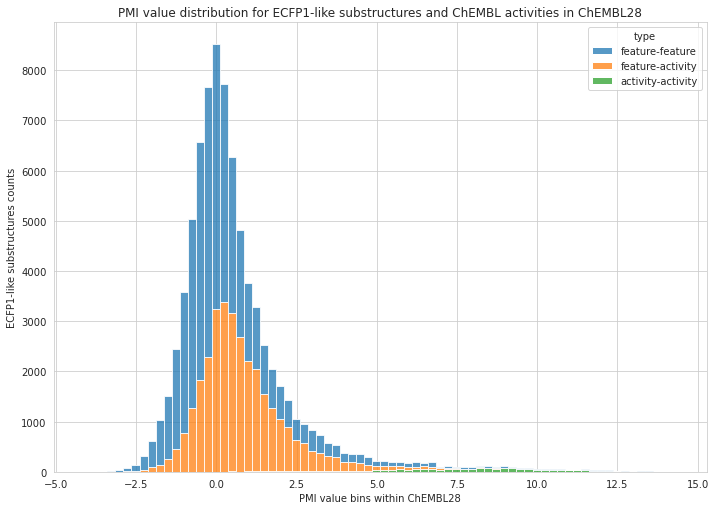

In [43]:
title = f"PMI value distribution for {HYBRID_FEATURES_NAME} in {DATASET_NAME}"
a4_dims = (11.7, 8.27)
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=a4_dims)
sns.histplot(q.select_raw_interrelations(), binwidth=0.25, x="value", hue="type", multiple="stack")
ax.set(title=title, xlabel=f"PMI value bins within {DATASET_NAME}", ylabel=f"{FEATURES_NAME} counts")
plt.savefig(f"{OUTPUT_FIGURE_PATH}/{title}.svg", format="svg")
#plt.close()

In [44]:
q.df.loc[q.df.type == 'activity-activity'].sort_values('value', ascending=False)[:100]

,,value,type
feature1,feature2,,
Amylin receptor AMY3; CALCR/RAMP3,Calcitonin receptor,13.727699,activity-activity
Retinoid X receptor beta,Retinoid X receptor gamma,13.497888,activity-activity
Neuronal acetylcholine receptor; alpha2/beta4,Neuronal acetylcholine receptor; alpha4/beta4,13.486818,activity-activity
HCC78,NCI-H2228,13.188010,activity-activity
Integrin alpha-V/beta-6,Integrin alpha-V/beta-8,13.161746,activity-activity
...,...,...,...
PRMT5/MEP50 complex,Protein arginine N-methyltransferase 5,11.497524,activity-activity
LXR-alpha,LXR-beta,11.492114,activity-activity
Protein kinase C delta,Protein kinase C eta,11.483970,activity-activity
